![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# Text Mining: LDA

Load libraries and data:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import re
import pandas as pd
import numpy as np
import string
import csv

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import SnowballStemmer     
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
stop_words = set(stopwords.words('english'))
 
import os
from re import sub

from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image




path = '/content/drive/MyDrive/Text Mining/'


Mounted at /content/drive
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Loading our two datasets
fake_news = pd.read_csv(os.path.join(path, "Fake.csv"), sep=',', encoding='utf-8')
true_news = pd.read_csv(os.path.join(path, "True.csv"), sep=',', encoding='utf-8')
print(fake_news.info())
print(true_news.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
None


In [ ]:
fake_news.head(2)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"


We generate new dataframes with two columns: "token" (each row is one token, contains all the tokens in the corpus) and "POS" (defines if the token is a noun, verb, etc):

In [ ]:
fake_news_POS = pd.DataFrame(columns =['Token', 'POS'])

for i in tqdm(list(fake_news["text"])):
    
    # Word tokenizers is used to find the words and punctuation in a string:
    wordsList = nltk.word_tokenize(i)
 
    # Generate a df with two columns: one with each of the tokens in the document, the other with its POS:
    df1 = pd.DataFrame(nltk.pos_tag(wordsList), columns =['Token', 'POS'])
    
    # Concatenate it with the previous ones:
    fake_news_POS = pd.concat([fake_news_POS, df1])

fake_news_POS.to_csv(path + "fake_news_POS.csv")

We do the same for the news that are not fake:

In [ ]:
true_news_POS = pd.DataFrame(columns =['Token', 'POS'])

for i in tqdm(list(true_news["text"])):
    
    # Word tokenizers is used to find the words and punctuation in a string:
    wordsList = nltk.word_tokenize(i)
 
    # Generate a df with two columns: one with each of the tokens in the document, the other with its POS:
    df1 = pd.DataFrame(nltk.pos_tag(wordsList), columns =['Token', 'POS'])
    
    # Concatenate it with the previous ones:
    true_news_POS = pd.concat([true_news_POS, df1])

true_news_POS.to_csv(path + "true_news_POS.csv")

100%|██████████| 21417/21417 [58:12<00:00,  6.13it/s]


We save the dataframes into csv files, for faster resuming in the future:

In [ ]:
fake_news_POS = pd.read_csv(path + "fake_news_POS.csv")
true_news_POS = pd.read_csv(path + "true_news_POS.csv")

nltk's tagger has many different and precise cathegories for Parts of Speech, including many types of nouns, verb tenses, etc. In order to summarize the data, we group the POS into fewer sets:

In [ ]:
# sets:
verbs = ["VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]
nouns = ["NN", "NNS", "NNP", "NNPS"]
adjectives = ["JJ", "JJR", "JJS"]
adverbs = ["RB", "RBR", "RBS", "WRB"]
conjuctions = ["IN", "CC"]
determiners = ["WDT", "DT"]
others = list(set(list(fake_news_POS["POS"].value_counts().reset_index()["index"])) - 
              set(verbs + nouns + adjectives + adverbs + conjuctions + determiners)) #everything that's considered in the above categories.


# now we add a column to each DF with this classification:
def pos_grouper(POS):
  if POS in verbs: return "verbs"
  if POS in nouns: return "nouns"
  if POS in adjectives: return "adjectives"
  if POS in adverbs: return "adverbs"
  if POS in conjuctions: return "conjuctions"
  if POS in determiners: return "determiners"
  if POS in others: return "others"

fake_news_POS["grouped_POS"] = fake_news_POS["POS"].apply(pos_grouper)
true_news_POS["grouped_POS"] = true_news_POS["POS"].apply(pos_grouper)

true_news_POS.head(2)

,Unnamed: 0,Token,POS,grouped_POS
0,0,WASHINGTON,NNP,nouns
1,1,(,(,others


Usage of Parts of Speech in our Fake and True news datasets:

In [ ]:
fake_news_POS["grouped_POS"].value_counts().reset_index()["grouped_POS"]

0    3279985
1    2273576
2    1766081
3    1476199
4     995435
5     747313
6     490800
Name: grouped_POS, dtype: int64

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

labels = list(fake_news_POS["grouped_POS"].value_counts().reset_index()["index"])



# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, values=list(true_news_POS["grouped_POS"].value_counts().reset_index()["grouped_POS"]), name="True News, POS"),
              1, 1)
fig.add_trace(go.Pie(labels=labels, values=list(fake_news_POS["grouped_POS"].value_counts().reset_index()["grouped_POS"]), name="Fake News, POS"),
              1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.3, direction ='clockwise', hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Parts of Speech in our News Dataset",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='True', x=0.19, y=0.5, font_size=20, showarrow=False),
                 dict(text='Fake', x=0.81, y=0.5, font_size=20, showarrow=False)],
    autosize=False,
    width=1000,
    height=500)
fig.show()

Fake news seem to employ fewer nouns and many more adverbs.

Which are the most occurring nouns, verbs, adjectives and adverbs in each corpus?

In [ ]:
#first we do some preprocessing by removing some symbols and letter, nltk's tagger:
fake_news_POS = fake_news_POS[~fake_news_POS["Token"].isin(["’", "”", "s", "“", "@", "t"])] 
true_news_POS = true_news_POS[~true_news_POS["Token"].isin(["’", "”", "s", "“", "@", "t"])] 


In [ ]:
# get the top ten nouns, verbs, adjectives and adverbs:
fake_nouns = fake_news_POS[fake_news_POS["grouped_POS"] == "nouns"]["Token"].value_counts().reset_index()[:10]
true_nouns = true_news_POS[true_news_POS["grouped_POS"] == "nouns"]["Token"].value_counts().reset_index()[:10]
fake_verbs = fake_news_POS[fake_news_POS["grouped_POS"] == "verbs"]["Token"].value_counts().reset_index()[:10]
true_verbs = true_news_POS[true_news_POS["grouped_POS"] == "verbs"]["Token"].value_counts().reset_index()[:10]
fake_adjectives = fake_news_POS[fake_news_POS["grouped_POS"] == "adjectives"]["Token"].value_counts().reset_index()[:10]
true_adjectives = true_news_POS[true_news_POS["grouped_POS"] == "adjectives"]["Token"].value_counts().reset_index()[:10]
fake_adverbs = fake_news_POS[fake_news_POS["grouped_POS"] == "adverbs"]["Token"].value_counts().reset_index()[:10]
true_adverbs = true_news_POS[true_news_POS["grouped_POS"] == "adverbs"]["Token"].value_counts().reset_index()[:10]

In [ ]:
# show the tables:
fig = make_subplots(
    rows=4, cols=2,
    vertical_spacing=0.03,
    specs=[[{"type": "table"},{"type": "table"}], 
           [{"type": "table"},{"type": "table"}],
           [{"type": "table"},{"type": "table"}],
           [{"type": "table"},{"type": "table"}]],)

# nouns:
fig.add_trace(
    go.Table(
        header=dict(
            values=["Fake - Nouns", "Freq"],
            font=dict(size=10),
            align="center", fill_color = "salmon"
        ),
        cells=dict(
            values=[fake_nouns["index"].tolist(), fake_nouns["Token"]],
            align = "left")
    ), row=1, col=1)

fig.add_trace(
    go.Table(
        header=dict(
            values=["True - Nouns", "Freq"],
            font=dict(size=10),
            align = "center", fill_color = "salmon"
        ),
        cells=dict(
            values=[true_nouns["index"].tolist(), true_nouns["Token"]],
            align = "left")
    ), row=1, col=2)

# verbs:
fig.add_trace(
    go.Table(
        header=dict(
            values=["Fake - Verbs", "Freq"],
            font=dict(size=10),
            align = "center", fill_color = "lightsteelblue"
        ),
        cells=dict(
            values=[fake_verbs["index"].tolist(), fake_verbs["Token"]],
            align = "left")
    ), row=2, col=1)

fig.add_trace(
    go.Table(
        header=dict(
            values=["True - Verbs", "Freq"],
            font=dict(size=10),
            align="center", fill_color = "lightsteelblue"
        ),
        cells=dict(
            values=[true_verbs["index"].tolist(), true_verbs["Token"]],
            align = "left")
    ), row=2, col=2)

# adjectives:
fig.add_trace(
    go.Table(
        header=dict(
            values=["Fake - Adjectives", "Freq"],
            font=dict(size=10),
            align="center", fill_color = "limegreen"
        ),
        cells=dict(
            values=[fake_adjectives["index"].tolist(), fake_adjectives["Token"]],
            align = "left")
    ), row=3, col=1)

fig.add_trace(
    go.Table(
        header=dict(
            values=["True - Adjectives", "Freq"],
            font=dict(size=10),
            align="center", fill_color = "limegreen"
        ),
        cells=dict(
            values=[true_adjectives["index"].tolist(), true_adjectives["Token"]],
            align = "left")
    ), row=3, col=2)

# adverbs:
fig.add_trace(
    go.Table(
        header=dict(
            values=["Fake - Adverbs", "Freq"],
            font=dict(size=10),
            align="center", fill_color = "lightslategrey"
        ),
        cells=dict(
            values=[fake_adverbs["index"].tolist(), fake_adverbs["Token"]],
            align = "left")
    ), row=4, col=1)

fig.add_trace(
    go.Table(
        header=dict(
            values=["True - Adverbs", "Freq"],
            font=dict(size=10),
            align="center", fill_color = "lightslategrey"
        ),
        cells=dict(
            values=[true_adverbs["index"].tolist(), true_adverbs["Token"]],
            align = "left")
    ), row=4, col=2)

fig.update_layout(
    height=1200,
    width = 800,
    showlegend=False,
    title_text="Top 10 Nouns, Verbs, Adjectives and Adverbs for Fake and True News",)

fig.show()

## LDA

In order to make the analysis computationally cheaper, to the typical removal of Punctuation, Numbers and Symbols, we add Verbs, Ad-positional phrases, Determiners, Pronouns, Auxiliaries, Adverbs, Coordinating and Subordinating Conjunctions.

Specifying topics can be efficiently done by focusing on the people, places and events -public figures, countries, elections, pandemics, scandals, etc.- that are mentioned in the documents. This information is typically represented in the articles’ Nouns.

Despite Adjectives being normally examined for Sentiment Analysis and occasionally disregarded for Topic Modeling, in our case they offer added value when considering n-grams, that is, groups of n tokens that are found together. In our context, for instance, ’White’ and ’House’ alone have very different meanings from ’White House’.

Initially we thought of a dictionary based approach, where we saved all the nouns and adjectives in a list, and then filtered out all the words that were not in it. 

We found problems with this, since sometimes the exact same word plays different roles in a sentence: for instance, "He gave him the <font color='blue'>look</font>" and "You <font color='blue'>look</font> nice". "Look" acts as a noun in the first case, and as a verb in the second.

This is why we filtered tokens out considering their roles in the sentences instead of the words themselves.

## Removing tokens based on POS:

In [ ]:
# we generate a new column in the dataframes with which document the token corresponds to
doc_tag =[0]
tag = 0
for row in range(1,len(true_news_POS["Unnamed: 0"])):
  if true_news_POS["Unnamed: 0"].iloc[row] > true_news_POS["Unnamed: 0"].iloc[row-1]:
    doc_tag.append(tag)
  else: 
    tag = tag+1
    doc_tag.append(tag)

In [ ]:
doc_tag1 =[0]
tag1 = 0
for row in range(1,len(fake_news_POS["Unnamed: 0"])):
  if fake_news_POS["Unnamed: 0"].iloc[row] > fake_news_POS["Unnamed: 0"].iloc[row-1]:
    doc_tag1.append(tag1)
  else: 
    tag1 = tag1+1
    doc_tag1.append(tag1)

In [ ]:
true_news_POS["doc_tag"] = doc_tag
fake_news_POS["doc_tag"] = doc_tag1

In [ ]:
# we keep only nouns and adjectives
true_rebuilt = true_news_POS[(true_news_POS["grouped_POS"] == "nouns") | (true_news_POS["grouped_POS"] == "adjectives")]
fake_rebuilt = fake_news_POS[(fake_news_POS["grouped_POS"] == "nouns") | (fake_news_POS["grouped_POS"] == "adjectives")]

,Unnamed: 0,Token,POS,grouped_POS,doc_tag
0,0,Donald,NNP,nouns,0
1,1,Trump,NNP,nouns,0
5,5,wish,JJ,adjectives,0
7,7,Americans,NNPS,nouns,0
9,9,Happy,JJ,adjectives,0
...,...,...,...,...,...
11029384,976,21st,JJ,adjectives,22850
11029385,977,Century,NNP,nouns,22850
11029386,978,Wire,NNP,nouns,22850
11029387,979,Iran,NNP,nouns,22850


In [ ]:
len(fake_rebuilt.doc_tag.unique())

22846

In [ ]:
# we rebuild the articles with only nouns and adjectives, and see how they look:
fake_articles = []
for doc in range(fake_rebuilt["doc_tag"].max()+1):
  try: #since some articles are void when removing POS
    fake_articles.append(" ".join(fake_rebuilt[fake_rebuilt["doc_tag"] == doc]["Token"].to_list()))
  except:
    continue 
print(len(fake_articles))
print(fake_articles[0])

22835
Donald Trump wish Americans Happy New Year shout enemies haters dishonest fake news media former reality show star job Country stronger friends supporters enemies haters dishonest Fake News Media Happy Healthy New Year President Angry Pants great year America Country stronger friends supporters enemies haters dishonest Fake News Media Happy Healthy New Year great year America Donald J. Trump realDonaldTrump December tweet welll kind president New Year despicable petty infantile gibberish Trump lack decency gutter American citizens happy new year Bishop Talbert Swan TalbertSwan December likes Calvin calvinstowell December impeachment great year America accept control Congress Miranda Yaver December talk many people Alan Sandoval AlanSandoval13 December word Haters New Years Marlene marlene399 December happy new year Koren pollitt Korencarpenter December Trump New Year Eve tweet New Year many enemies Donald J. Trump realDonaldTrump December nothing new Trump years.Trump messages en

In [ ]:
true_articles = []
for doc in range(true_rebuilt["doc_tag"].max()+1):
  try:
    true_articles.append(" ".join(true_rebuilt[true_rebuilt["doc_tag"] == doc]["Token"].to_list()))
  except:
    continue
print(len(true_articles))
print(true_articles[0])

21397
WASHINGTON Reuters head conservative Republican faction U.S. Congress month huge expansion national debt tax cuts fiscal conservative Sunday budget restraint sharp pivot way Republicans U.S. Representative Mark Meadows CBS Face Nation hard line federal spending lawmakers battle January holidays Wednesday lawmakers federal budget fight other issues such immigration policy November congressional election campaigns approach Republicans control Congress President Donald Trump Republicans big budget increase military spending Democrats proportional increases non-defense discretionary spending programs education scientific research infrastructure public health environmental protection Trump administration willing ‘ non-defense discretionary spending percent Meadows chairman small influential House Freedom Caucus program Democrats government pay raise percent fiscal conservative see rationale other people money Meadows Republicans late December party debt-financed tax overhaul federal b

In [ ]:
# we generate new dataframes:
true_news_LDA = pd.DataFrame(columns = ["id", "text"])
true_news_LDA["id"] = list(range(len(true_articles)))
true_news_LDA["text"] = true_articles

fake_news_LDA = pd.DataFrame(columns = ["id", "text"])
fake_news_LDA["id"] = list(range(len(fake_articles)))
fake_news_LDA["text"] = fake_articles

print(true_news_LDA.head(2))
print(fake_news_LDA.head(2))

   id                                               text
0   0  WASHINGTON Reuters head conservative Republica...
1   1  WASHINGTON Reuters Transgender people first ti...
   id                                               text
0   0  Donald Trump wish Americans Happy New Year sho...
1   1  House Intelligence Committee Chairman Devin Nu...


In [ ]:
# As a summary, we have:
print("========For Fake News========")
print("We start with {} tokens".format(fake_news_POS.shape[0]))
print("After removing all POSs except Nouns and Adjectives, we have {} ({:.1f}%) tokens left".format(fake_rebuilt.shape[0], fake_rebuilt.shape[0]*100/fake_news_POS.shape[0]))
print("\n")
print("========For True News========")
print("We start with {} tokens".format(true_news_POS.shape[0]))
print("After removing all POSs except Nouns and Adjectives, we have {} ({:.1f}%) tokens left".format(true_rebuilt.shape[0], true_rebuilt.shape[0]*100/true_news_POS.shape[0]))


========For Fake News========
We start with 10832547 tokens
After removing all POSs except Nouns and Adjectives, we have 3920615 (36.2%) tokens left


========For True News========
We start with 9034747 tokens
After removing all POSs except Nouns and Adjectives, we have 3581407 (39.6%) tokens left


In [ ]:
# save into files for faster resuming:
fake_news_LDA.to_csv(path + "fake_news_LDA.csv")
true_news_LDA.to_csv(path + "true_news_LDA.csv")

In [ ]:
fake_news_LDA

,id,text
0,0,Donald Trump wish Americans Happy New Year sho...
1,1,House Intelligence Committee Chairman Devin Nu...
2,2,Friday former Milwaukee Sheriff David Clarke H...
3,3,Christmas day Donald Trump following day fourt...
4,4,Pope Francis annual Christmas Day message Dona...
...,...,...
22830,22830,21st Century Wire week unlikely mishap US Nava...
22831,22831,21st Century Wire familiar theme dispute chang...
22832,22832,Patrick Henningsen 21st Century WireRemember O...
22833,22833,21st Century Wire Al Jazeera America history b...


## Further pre-processing:

We continue with some preprocessing of the texts employing a slightly modified version of the tools we have seen in class:

In [ ]:
fake_news_LDA = pd.read_csv(path + "fake_news_LDA.csv")
true_news_LDA = pd.read_csv(path + "true_news_LDA.csv")

In [ ]:
porter=SnowballStemmer("english") # we liked the results of using this stemmer better

stop_words = set(stopwords.words('english')) # we expect this to remove few words due to our extensive previous preprocessing

def abbr_or_lower(word):
  if re.match('([A-Z]+[a-z]*){2,}', word):
    return word
  else:
    return word.lower()

def tokenize(words):
  tokens = re.split(r'\W+', words)
  stems = []
  for token in tokens:
    lowers = abbr_or_lower(token)
    if lowers not in stop_words:
      if re.search('[a-zA-Z]', lowers):
        stems.append(porter.stem(lowers))

  return " ".join(stems)

print(fake_news_LDA["text"].iloc[0])
print(tokenize(fake_news_LDA["text"].iloc[0]))

Donald Trump wish Americans Happy New Year shout enemies haters dishonest fake news media former reality show star job Country stronger friends supporters enemies haters dishonest Fake News Media Happy Healthy New Year President Angry Pants great year America Country stronger friends supporters enemies haters dishonest Fake News Media Happy Healthy New Year great year America Donald J. Trump realDonaldTrump December tweet welll kind president New Year despicable petty infantile gibberish Trump lack decency gutter American citizens happy new year Bishop Talbert Swan TalbertSwan December likes Calvin calvinstowell December impeachment great year America accept control Congress Miranda Yaver December talk many people Alan Sandoval AlanSandoval13 December word Haters New Years Marlene marlene399 December happy new year Koren pollitt Korencarpenter December Trump New Year Eve tweet New Year many enemies Donald J. Trump realDonaldTrump December nothing new Trump years.Trump messages enemies 

In [ ]:
# we create new a column with the stemmed text
fake_news_LDA["stemmed"] = fake_news_LDA["text"].apply(str).apply(tokenize)
true_news_LDA["stemmed"] = true_news_LDA["text"].apply(str).apply(tokenize)

fake_news_LDA.head(2)
true_news_LDA.head(2)

,Unnamed: 0,id,text,stemmed
0,0,0,WASHINGTON Reuters head conservative Republica...,washington reuter head conserv republican fact...
1,1,1,WASHINGTON Reuters Transgender people first ti...,washington reuter transgend peopl first time u...


# LDA Model

In [ ]:
import gensim
from gensim import models
from gensim import corpora
from gensim.utils import simple_preprocess
from collections import defaultdict

# we generate a list with as many entries as news articles in each corpus, each entry being a list of the tokens associated with an article:
fake_list = []
true_list = []

for article in fake_news_LDA["stemmed"].to_list():
  fake_list.append(article.split(" "))

for article1 in true_news_LDA["stemmed"].to_list():
  true_list.append(article1.split(" "))

print(fake_list[0])
print(true_list[0])

['donald', 'trump', 'wish', 'american', 'happi', 'new', 'year', 'shout', 'enemi', 'hater', 'dishonest', 'fake', 'news', 'media', 'former', 'realiti', 'show', 'star', 'job', 'countri', 'stronger', 'friend', 'support', 'enemi', 'hater', 'dishonest', 'fake', 'news', 'media', 'happi', 'healthi', 'new', 'year', 'presid', 'angri', 'pant', 'great', 'year', 'america', 'countri', 'stronger', 'friend', 'support', 'enemi', 'hater', 'dishonest', 'fake', 'news', 'media', 'happi', 'healthi', 'new', 'year', 'great', 'year', 'america', 'donald', 'j', 'trump', 'realdonaldtrump', 'decemb', 'tweet', 'welll', 'kind', 'presid', 'new', 'year', 'despic', 'petti', 'infantil', 'gibberish', 'trump', 'lack', 'decenc', 'gutter', 'american', 'citizen', 'happi', 'new', 'year', 'bishop', 'talbert', 'swan', 'talbertswan', 'decemb', 'like', 'calvin', 'calvinstowel', 'decemb', 'impeach', 'great', 'year', 'america', 'accept', 'control', 'congress', 'miranda', 'yaver', 'decemb', 'talk', 'mani', 'peopl', 'alan', 'sandov',

### For Fake News:

In [ ]:
# Making bigrams and trigrams
# The main arguments of gensim's bigram and trigram functions are 'min_count' and 'threshold'. 
# The higher their values, the harder it is for words to be combined into bi/trigrams.

bigram = gensim.models.Phrases(fake_list, min_count=10, threshold=10) #the higher min_count and threshold, the fewer n-grams
trigram = gensim.models.Phrases(bigram[fake_list], threshold=10)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

texts_bigrams = [bigram_mod[doc] for doc in fake_list]
texts = [trigram_mod[doc] for doc in fake_list]

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
# generate dictionary and corpus objects to pass to the model:
frequency = defaultdict(int)

for text in texts:
    for token in text:
        frequency[token] += 1

dictionary = corpora.Dictionary([[token for token in text if frequency[token] > 1] for text in texts])
dictionary.filter_extremes(no_below = 10, no_above=0.8)
print(dictionary)

corpus = [dictionary.doc2bow(text) for text in texts]

Dictionary(20428 unique tokens: ['accept', 'alan', 'america', 'american', 'american_citizen']...)


At this point, we have two of the three main arguments gensim's LDA model requires:

- The preprocessed corpus
- The associated dictionary

Now we have to determine the number of topics we want it to work with. This task can be done by computing different diagnostic values such as the Held-Out Likelihoods, Semantic Coherence, Residuals and others a LB for different numbers of Topics. And then choosing an "optimal" $k$.

In our case, we tried between 8 to 12 topics, ran the model for each case and picked looked at the results. We settled for 8 topics.

Additional important arguments for gensim's LDA model are:

- alpha: A-priori belief on document-topic distribution.
- eta: A-priori belief on topic-word distribution.

Since we have no prior insights on how topics or words within topics could be distributed, we will not input these.

In [ ]:
topicnumber = 8

LDA_model = models.LdaModel(corpus, id2word=dictionary, num_topics=topicnumber)

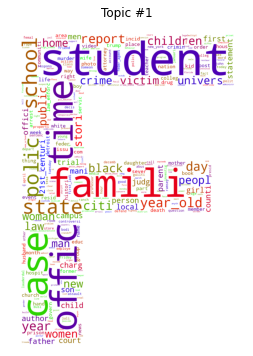

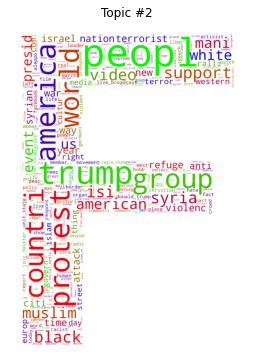

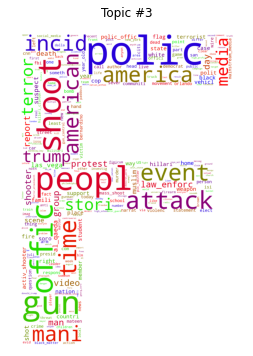

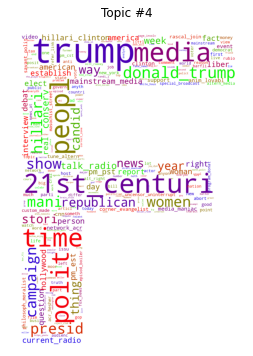

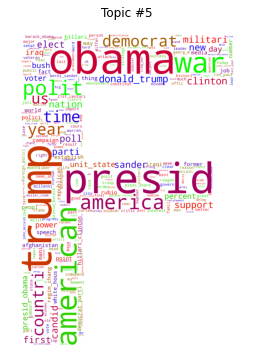

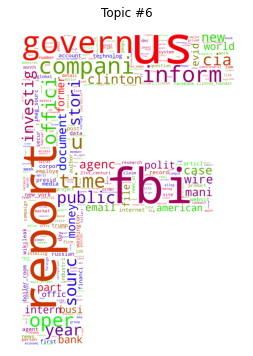

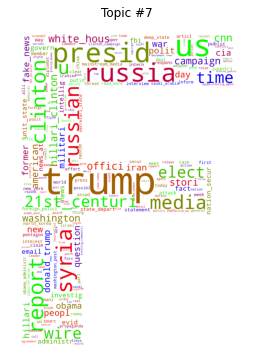

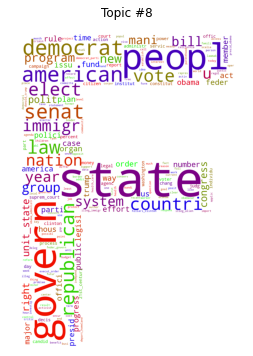

In [ ]:
def wordcloud_t(data, title):
    cloud = WordCloud(scale=3,
                      max_words=300,
                      colormap='brg',
                      mask = np.array(Image.open(path + 'F2.png')),
                      background_color='white',
                      stopwords=stopwords,
                      collocations=True)
                      #contour_color='black',
                      #contour_width=0.1)
    plt.figure(figsize=(8,6))
    plt.imshow(cloud.fit_words(data))
    plt.axis('off')
    plt.title(title)
    plt.show()

for t in range(LDA_model.num_topics):
  wordcloud_t(dict(LDA_model.show_topic(t, 300)), 'Topic #{}'.format(t+1))

In [ ]:
#!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models 

pyLDAvis.enable_notebook()
vis1 = pyLDAvis.gensim_models.prepare(LDA_model, corpus, dictionary, sort_topics=False)
vis1

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.111783  0.107108       1        1  11.992466
1     -0.106328 -0.072151       2        1  14.068724
2     -0.130692  0.021487       3        1   9.950928
3      0.011176 -0.087728       4        1  13.580500
4      0.050675 -0.130061       5        1   9.951444
5      0.103015  0.123012       6        1   9.868967
6      0.127994 -0.001884       7        1  14.785045
7      0.055942  0.040218       8        1  15.801927, topic_info=       Term          Freq         Total Category  logprob  loglift
72    trump  30991.000000  30991.000000  Default  30.0000  30.0000
290   obama  10165.000000  10165.000000  Default  29.0000  29.0000
618  russia   5360.000000   5360.000000  Default  28.0000  28.0000
58   presid  17663.000000  17663.000000  Default  27.0000  27.0000
224   polic   5583.000000   5583.000000  Default  26.0000  26.0000
..      ...           ...           ...      ...      ...      ...
49      new   2106.060334   9759.181074   Topic8  -5.4532   0.3116
616   right   1775.454286   6060.218843   Topic8  -5.6240   0.6173
44     mani   2034.839609  10377.533585   Topic8  -5.4876   0.2158
489   polit   1902.716366  10876.524742   Topic8  -5.5548   0.1017
151    time   1721.780878  15802.408783   Topic8  -5.6547  -0.3718

[791 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
11539      1  0.108431  21st_centuri
11539      3  0.004532  21st_centuri
11539      4  0.365857  21st_centuri
11539      5  0.052686  21st_centuri
11539      6  0.063110  21st_centuri
...      ...       ...           ...
1433       8  0.028208   year_prison
16364      1  0.965842      youngest
16364      2  0.027861      youngest
10606      1  0.993042    yugoslavia
16049      6  0.984430           zor

[2903 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
pyLDAvis.save_html(vis1, path +'LDA_fake2.html')

Interpreting the visualization tool:

Left side panel:
-  It offers a representation of how topics are distributed in the 2-dimensional space (based on PCA). The larger the bubble, the more frequent is the topic in the documents.

  Typically, topic models with low numbers of topics have large bubbles than tend to not overlap. Topic models with high numbers of topics, on the other hand, have many overlapping small size bubbles.

- Intertopic Distance is an approximation of semantic relationship between the topics. Those that share many terms will be closer and tend to overlap.

Horizontal Bar Graph:

- The blue bars in the graph show the frequency distribution of the words in all of the documents.

- The red portion of the bars describe the frequency of each word, given a topic.

Interactivity:

- You can select a topic by clicking on a topic bubble. This will show the top 30 words associated with it, and their proportion in terms of total frequency.

- Hovering over the specific words, the topics containing those words are highlighted. The higher the proportion of that word in a topic, the larger the size of the bubble.

- You can play with the lambda parameter to re-rank words in topics based on their frequency. Decreasing the lambda parameter, increases the weight of the ratio of the frequency of word given the topic / Overall frequency of the word in the documents.

### For True News:

In [ ]:
# Making bigrams and trigrams
# The main arguments of gensim's bigram and trigram functions are 'min_count' and 'threshold'. 
# The higher their values, the harder it is for words to be combined into bi/trigrams.

bigram = gensim.models.Phrases(true_list, min_count=10, threshold=10)
trigram = gensim.models.Phrases(bigram[true_list], threshold=10)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

texts_bigrams = [bigram_mod[doc] for doc in true_list]
texts = [trigram_mod[doc] for doc in true_list]

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
frequency = defaultdict(int)

for text in texts:
    for token in text:
        frequency[token] += 1

dictionary = corpora.Dictionary([[token for token in text if frequency[token] > 1] for text in texts])
dictionary.filter_extremes(no_below = 10, no_above=0.8)
print(dictionary)

corpus = [dictionary.doc2bow(text) for text in texts]

Dictionary(18821 unique tokens: ['aid', 'aid_packag', 'approach', 'assist', 'battl']...)


In [ ]:
topicnumber = 8

LDA_model = models.LdaModel(corpus, id2word=dictionary, num_topics=topicnumber)

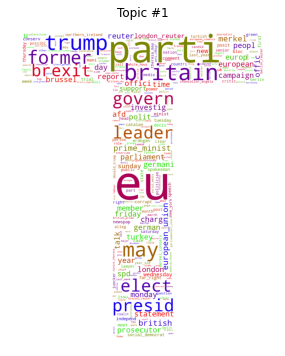

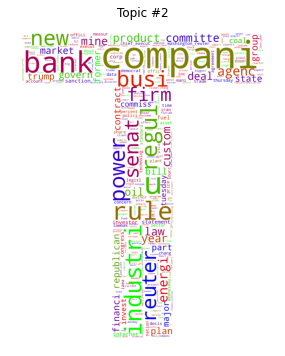

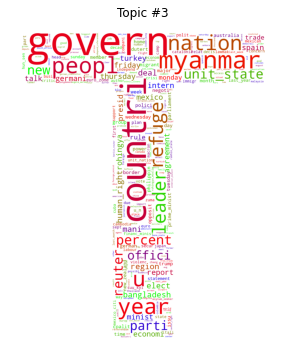

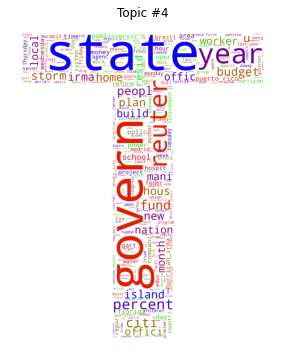

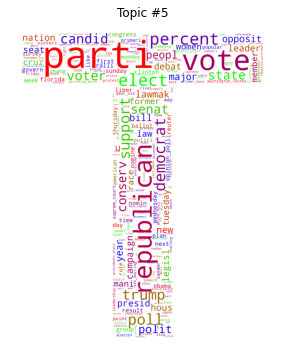

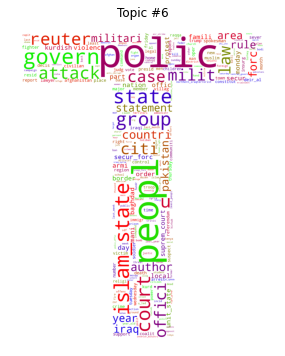

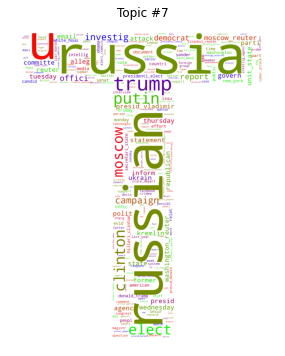

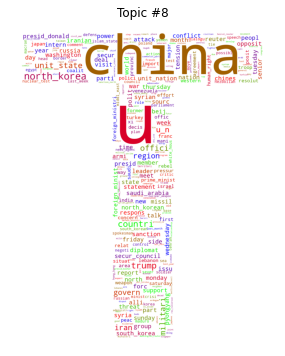

In [ ]:
def wordcloud_t(data, title):
    cloud = WordCloud(scale=3,
                      max_words=300,
                      colormap='brg',
                      mask = np.array(Image.open(path + 't3.png')),
                      background_color='white',
                      stopwords=stopwords,
                      collocations=True)
                      #contour_color='black',
                      #contour_width=0.1)
    plt.figure(figsize=(8,6))
    plt.imshow(cloud.fit_words(data))
    plt.axis('off')
    plt.title(title)
    plt.show()

for t in range(LDA_model.num_topics):
  wordcloud_t(dict(LDA_model.show_topic(t, 300)), 'Topic #{}'.format(t+1))

In [ ]:
vis = pyLDAvis.gensim_models.prepare(LDA_model, corpus, dictionary, sort_topics=False)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.152260 -0.018231       1        1  10.414881
1     -0.142302  0.077536       2        1   9.357324
2     -0.018648 -0.088139       3        1  10.456555
3     -0.152943  0.013273       4        1   9.657804
4      0.035632  0.155064       5        1  17.619286
5     -0.029460 -0.105403       6        1  12.186973
6      0.112329  0.101683       7        1  11.584343
7      0.043132 -0.135781       8        1  18.722835, topic_info=           Term          Freq         Total Category  logprob  loglift
100       parti  27519.000000  27519.000000  Default  30.0000  30.0000
402     russian   9613.000000   9613.000000  Default  29.0000  29.0000
343      russia  10782.000000  10782.000000  Default  28.0000  28.0000
5039         eu   5939.000000   5939.000000  Default  27.0000  27.0000
151        vote  13326.000000  13326.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
103       peopl   1793.591541  14262.308878   Topic8  -5.6863  -0.3980
262   statement   1651.036307   7167.489325   Topic8  -5.7692   0.2073
331       polit   1645.080157   8757.275916   Topic8  -5.7728   0.0033
156   wednesday   1617.889117   7433.433308   Topic8  -5.7894   0.1506
760       state   1652.722235  15038.132124   Topic8  -5.7681  -0.5327

[711 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
10288      5  0.003050  abadi
10288      6  0.988275  abadi
10288      8  0.006100  abadi
2639       2  0.008648  abort
2639       3  0.002162  abort
...      ...       ...    ...
17733      4  0.025490   zuma
17733      5  0.031862   zuma
17733      6  0.012745   zuma
17733      7  0.006372   zuma
17733      8  0.010621   zuma

[2642 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
pyLDAvis.save_html(vis, path +'LDA_true.html')